**IMPORTING LIBRARIES**

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import text_hammer as th
import seaborn as sns
import matplotlib.pyplot as plt
import re
import h5py
from tensorflow.keras.models import load_model
from wordcloud import STOPWORDS
from collections import defaultdict
#%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from transformers import AutoTokenizer,TFBertModel

max_len = 36

import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.5 MB/s 
     |████████████████████████████████| 895 kB 38.4 MB/s 
     |████████████████████████████████| 6.5 MB 33.5 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
     |████████████████████████████████| 596 kB 42.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


**LOADING THE DATA:**

In [ ]:
train_data = pd.read_csv('train.csv',usecols=['id','text','target'])
test_data = pd.read_csv('test.csv',usecols=['id','text'])

In [ ]:
test_data.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_data.shape

(7613, 3)

In [ ]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
#     df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

In [ ]:
train_cleaned_data = text_preprocessing(train_data,'text')

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

In [ ]:
train_cleaned_data[train_cleaned_data.target == 0]

,id,text,target
15,23,whats up man,0
16,24,i love fruits,0
17,25,summer is lovely,0
18,26,my car is so fast,0
19,28,what a goooooooaaaaaal,0
...,...,...,...
7581,10833,engineshed great atmosphere at the british lio...,0
7582,10834,cramer igers 3 words that wrecked disneys stoc...,0
7584,10837,these boxes are ready to explode exploding kit...,0
7587,10841,sirens everywhere,0


In [ ]:
train_data = train_cleaned_data.copy()

In [ ]:
train_data.head(10)

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,just got sent this photo from ruby alaska as s...,1
5,8,rockyfire update california hwy 20 closed in b...,1
6,10,flood disaster heavy rain causes flash floodin...,1
7,13,im on top of the hill and i can see a fire in ...,1
8,14,theres an emergency evacuation happening now i...,1
9,15,im afraid that the tornado is coming to our area,1


Here, 

* Target 1 indicates any accident or disaster 

* Target 0 indicates a formal tweets with not much attention


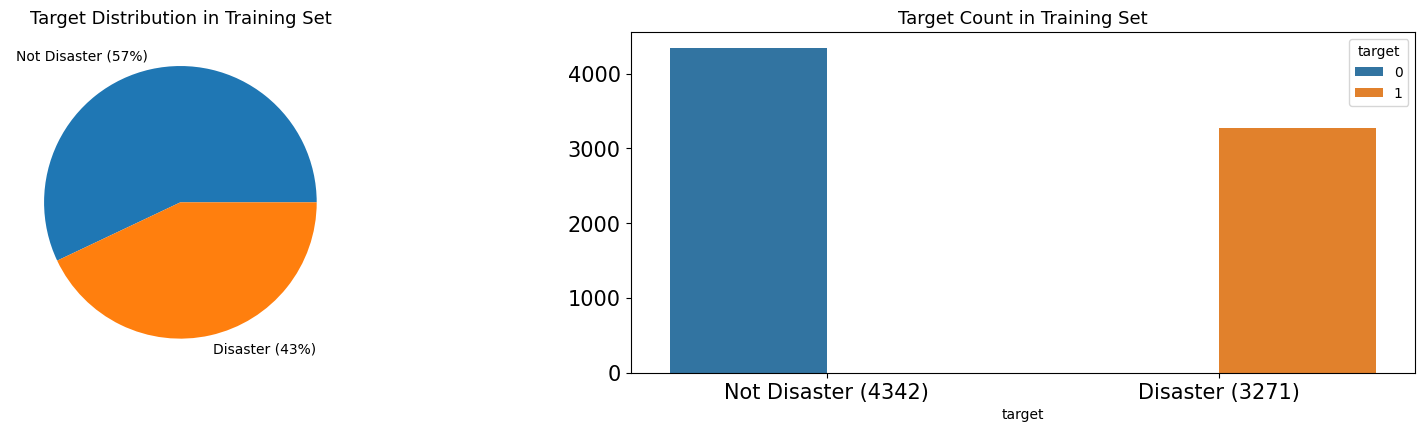

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train_data.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=train_data['target'], hue=train_data['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

**LOADING THE BERT MODEL:**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


**CONVERSION OF OUR TEXT DATA INTO BERT INPUT FORMAT:**

In [ ]:
print("max len of tweets",max([len(x.split()) for x in train_data.text]))
max_length = 36

max len of tweets 24


In [ ]:
x_train = tokenizer(
    text=train_data.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
x_train['input_ids'].shape

TensorShape([7613, 36])

In [ ]:
x_train['attention_mask'].shape

TensorShape([7613, 36])

In [ ]:
y_train = train_data.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
train_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

**BUILDING THE MODEL ARCHITECTURE:**

In [ ]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

# for training bert our lr must be so small


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 36)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 36)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 36,                                            

In [ ]:
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model.
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

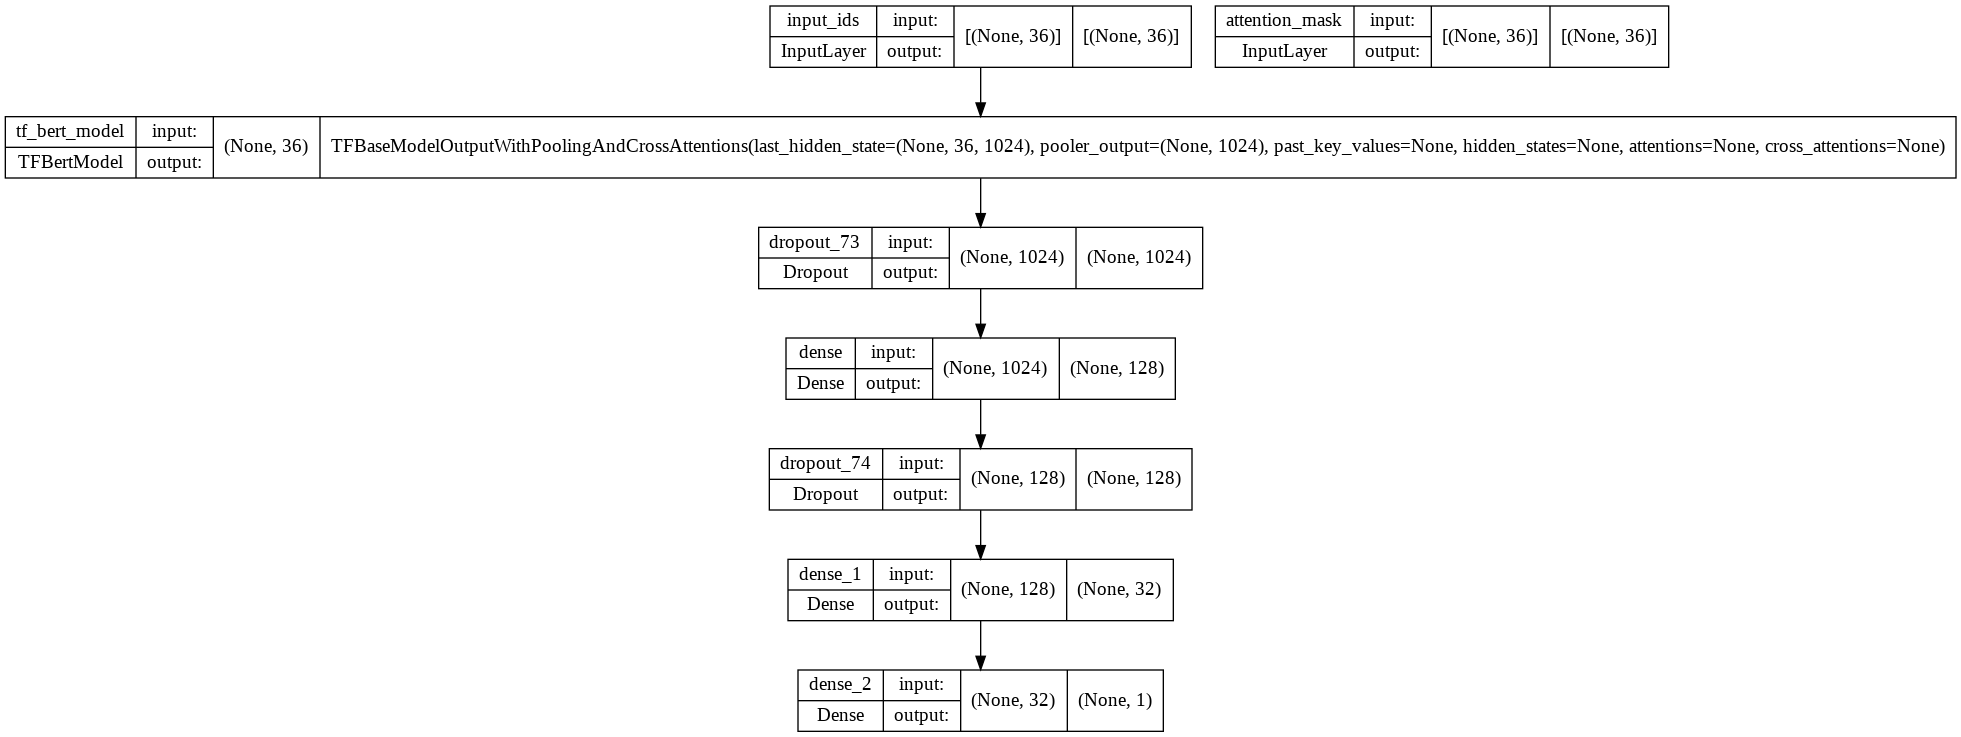

In [ ]:
plot_model(model, show_shapes = True)

In [ ]:
# Fit the model
final = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
#   validation_split = 0.1,
  epochs=9,
    batch_size=10
)

Epoch 1/9
762/762 [==============================] - 613s 719ms/step - loss: 0.5861 - accuracy: 0.6975
Epoch 2/9
762/762 [==============================] - 545s 715ms/step - loss: 0.4901 - accuracy: 0.7955
Epoch 3/9
762/762 [==============================] - 545s 715ms/step - loss: 0.4605 - accuracy: 0.8131
Epoch 4/9
762/762 [==============================] - 545s 715ms/step - loss: 0.4551 - accuracy: 0.8144
Epoch 5/9
762/762 [==============================] - 546s 716ms/step - loss: 0.4420 - accuracy: 0.8173
Epoch 6/9
762/762 [==============================] - 545s 715ms/step - loss: 0.4323 - accuracy: 0.8267
Epoch 7/9
762/762 [==============================] - 545s 715ms/step - loss: 0.4248 - accuracy: 0.8304
Epoch 8/9
762/762 [==============================] - 545s 715ms/step - loss: 0.4268 - accuracy: 0.8267
Epoch 9/9
762/762 [==============================] - 544s 715ms/step - loss: 0.4231 - accuracy: 0.8309


**VISUALIZATION OF LOSS AND ACCURACY CURVE:**

In [ ]:
def visual_accuracy_and_loss(final):
    acc = final.history['accuracy']
    loss = final.history['loss']
    epochs_plot = np.arange(1, len(loss) + 1)
    plt.clf()
    plt.plot(epochs_plot, acc, 'r', label='Accuracy')
    plt.plot(epochs_plot, loss, 'b:', label='Loss')
    plt.title('VISUALIZATION OF LOSS AND ACCURACY CURVE')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

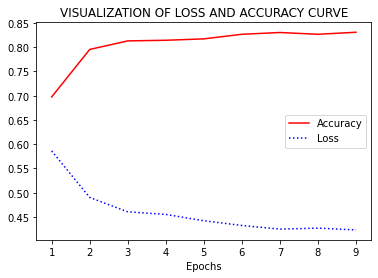

In [ ]:
visual_accuracy_and_loss(final)

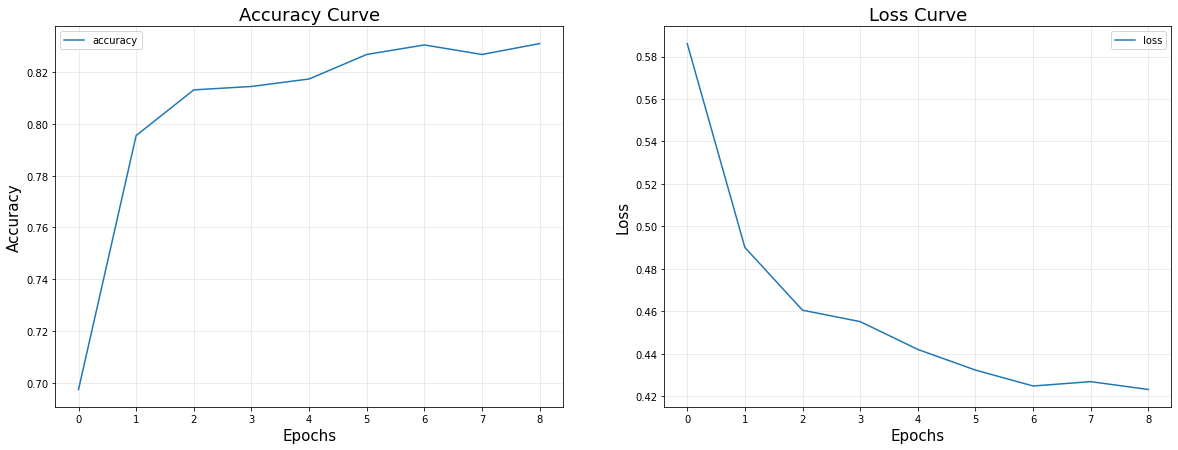

In [ ]:
# Plot the loss and accuracy curves  

#Diffining Figure
f = plt.figure(figsize=(20,7))

#Adding Subplot 1 (For Accuracy)
f.add_subplot(121)

plt.plot(final.epoch,final.history['accuracy'],label = "accuracy") # Accuracy curve 


plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(final.epoch,final.history['loss'],label="loss") # Loss curve 


plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()


In [ ]:
test_data['text'][4]

'Typhoon Soudelor kills 28 in China and Taiwan'

In [ ]:
x_test = tokenizer(
    text=test_data.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

**PREDICTION:**

In [ ]:
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

In [ ]:
y_predicted = np.where(predicted>0.5,1,0)

In [ ]:
y_predicted = y_predicted.reshape((1,3263))[0]

In [ ]:
sample_data = pd.DataFrame({'id':[],'target':[]})

In [ ]:
sample_data['id'] = test_data.id
sample_data['target'] = y_predicted

In [ ]:
sample_data.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
model.save('bert_tweet_prediction_model') 

INFO:tensorflow:Assets written to: bert_tweet_prediction_model/assets


INFO:tensorflow:Assets written to: bert_tweet_prediction_model/assets


In [ ]:
model.save_weights('bert_saved_weights')